#### Environment: Kaggle GPU
#### Training Time: 1.30 - 2hrs

In [ ]:
!nvidia-smi

Sat Nov 13 21:48:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -Uq gluoncv
!pip install -Uq mxnet
!pip install -q mxnet-cu110==1.8.0

In [ ]:
import os
import random 
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import mxnet as mx
import gluoncv as gcv

from gluoncv import utils
from gluoncv.data import LstDetection
from mxnet import autograd, gluon

from pathlib import Path

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.9.1` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [ ]:
seed = 42

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(seed)
mx.random.seed(seed)
utils.random.seed(seed)

In [ ]:
EPOCHS = 20

In [ ]:
try:
    a = mx.nd.zeros((1,), ctx=mx.gpu(0))
    ctx = [mx.gpu(0)]
except:
    ctx = [mx.cpu()]

In [ ]:
path = Path('/kaggle/input/passionfruit')
wrk_path = Path('/kaggle/working')

In [ ]:
train_path = path/'Train_Images/Train_Images'
test_path = path/'Test_Images/Test_Images'

In [ ]:
train = pd.read_csv(path/'Train.csv')

(3906, 6)

In [ ]:
train.head()

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


In [ ]:
train['Image_ID'] = train['Image_ID'].apply(lambda x: f'{x}.jpg')

In [ ]:
le = LabelEncoder()

train['class_int'] = le.fit_transform(train['class'])

In [ ]:
CLASSES = le.classes_.tolist()

In [ ]:
gkf = GroupKFold(n_splits=5)
train['fold'] = -1

for fold, (train_idx, val_idx) in enumerate(gkf.split(train, groups=train.Image_ID.tolist())):
    train.loc[val_idx, 'fold'] = fold
train.head(2)

,Image_ID,class,xmin,ymin,width,height,class_int,fold
0,ID_007FAIEI.jpg,fruit_woodiness,87.0,87.5,228.0,311.0,2,0
1,ID_00G8K1V3.jpg,fruit_brownspot,97.5,17.5,245.0,354.5,0,4


In [ ]:
train_df = train[train['fold'] != 0]
train_df.reset_index(inplace=True, drop=True)

In [ ]:
csv_bboxes = train[['xmin', 'ymin', 'width', 'height']].values
csv_image_ids = train['Image_ID'].to_numpy()
csv_classes = train['class_int'].to_numpy()

In [ ]:
def get_annot(image_name, csv_image_ids, csv_bboxes ):
    indexes = np.where(csv_image_ids==image_name)[0]
    if len(indexes)==0:
        raise ValueError('No data for ', image_name)
    boxes, classes = [], []
    for ind in indexes:
        x, y, w, h = csv_bboxes[ind]
        boxes.append(np.array([x, y, x+w, y+h]))
        c = csv_classes[ind]
        classes.append(c)
    boxes = np.array(boxes)
    classes = np.array(classes)
    return boxes, classes

Image shape:  (512, 512, 3)


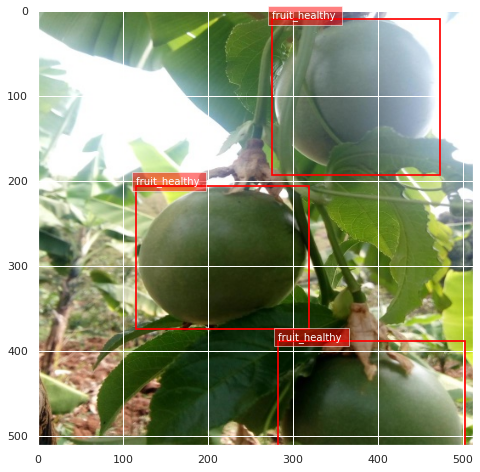

In [ ]:
img_loc = train_path/'ID_07HGJOFB.jpg'
img = mx.image.imread(img_loc)
print('Image shape: ', img.shape)
boxes, classes = get_annot('ID_07HGJOFB.jpg', csv_image_ids, csv_bboxes)
class_names = le.inverse_transform(classes)

plt.rcParams['figure.figsize'] = [8, 8]
ax = utils.viz.plot_bbox(img, boxes, class_names=class_names, absolute_coordinates=True, linewidth=1.7, fontsize=10)
plt.show()

## Prepare Dataset

In [ ]:
def write_line(img_path, im_shape, boxes, ids, idx):
    h, w, c = im_shape
    
    A = 4
    B = 5
    C = w
    D = h
    
    labels = np.hstack((ids.reshape(-1, 1), boxes)).astype('float')

    labels[:, (1, 3)] /= float(w)
    labels[:, (2, 4)] /= float(h)

    labels = labels.flatten().tolist()
    str_idx = [str(idx)]
    str_header = [str(x) for x in [A, B, C, D]]
    str_labels = [str(x) for x in labels]
    str_path = [img_path]
    line = '\t'.join(str_idx + str_header + str_labels + str_path) + '\n'
    return line

In [ ]:
with open(wrk_path/'train.lst', 'w') as fw:
    i = 0
    for file_name in train_df['Image_ID'].unique(): 
        try:
            boxes, classes = get_annot(file_name, csv_image_ids, csv_bboxes)
            file_path = f'{train_path}/{file_name}'
            img = mx.image.imread(file_path)
            line = write_line(file_path, img.shape, boxes, classes, i)
            fw.write(line)
            i = i + 1
        except Exception as e:
            print(e)

In [ ]:
train_dataset = LstDetection(wrk_path/'train.lst', root=os.path.expanduser('.') )

In [ ]:
net = gcv.model_zoo.get_model('ssd_512_resnet50_v1_voc', pretrained=True)

100%|██████████| 132723/132723 [00:06<00:00, 20982.44KB/s]


In [ ]:
net.reset_class(CLASSES)

In [ ]:
def get_dataloader(net, train_dataset, data_shape, batch_size, num_workers):
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
    width, height = data_shape, data_shape
    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width)))
    batchify_fn = Tuple(Stack(), Stack(), Stack()) 
    train_loader = gluon.data.DataLoader(
        train_dataset.transform(SSDDefaultTrainTransform(width, height, anchors)),
        batch_size, True, batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
    return train_loader

train_data = get_dataloader(net, train_dataset, 512, 8, 0)

## Training

In [ ]:
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9},)

mbox_loss = gcv.loss.SSDMultiBoxLoss()
ce_metric = mx.metric.Loss('CrossEntropy')
smoothl1_metric = mx.metric.Loss('SmoothL1')

for epoch in range(EPOCHS):
    ce_metric.reset()
    smoothl1_metric.reset()
    tic = time.time()
    btic = time.time()
    net.hybridize(static_alloc=True, static_shape=True)
    for i, batch in enumerate(train_data):
        batch_size = batch[0].shape[0]
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        cls_targets = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        box_targets = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)
        with autograd.record():
            cls_preds = []
            box_preds = []
            for x in data:
                cls_pred, box_pred, _ = net(x)
                cls_preds.append(cls_pred)
                box_preds.append(box_pred)
            sum_loss, cls_loss, box_loss = mbox_loss(
                cls_preds, box_preds, cls_targets, box_targets)
            autograd.backward(sum_loss)
        trainer.step(1)
        ce_metric.update(0, [l * batch_size for l in cls_loss])
        smoothl1_metric.update(0, [l * batch_size for l in box_loss])
        name1, loss1 = ce_metric.get()
        name2, loss2 = smoothl1_metric.get()
        if i % 500 == 0:
            print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))

[21:50:09] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


[Epoch 0][Batch 0], Speed: 0.692 samples/sec, CrossEntropy=12.117, SmoothL1=1.922
[Epoch 1][Batch 0], Speed: 10.568 samples/sec, CrossEntropy=2.078, SmoothL1=0.286
[Epoch 2][Batch 0], Speed: 11.124 samples/sec, CrossEntropy=1.897, SmoothL1=0.192
[Epoch 3][Batch 0], Speed: 11.376 samples/sec, CrossEntropy=2.027, SmoothL1=0.277
[Epoch 4][Batch 0], Speed: 10.535 samples/sec, CrossEntropy=1.907, SmoothL1=0.286
[Epoch 5][Batch 0], Speed: 11.073 samples/sec, CrossEntropy=1.143, SmoothL1=0.185
[Epoch 6][Batch 0], Speed: 12.146 samples/sec, CrossEntropy=1.398, SmoothL1=0.294
[Epoch 7][Batch 0], Speed: 11.051 samples/sec, CrossEntropy=0.750, SmoothL1=0.196
[Epoch 8][Batch 0], Speed: 12.068 samples/sec, CrossEntropy=0.938, SmoothL1=0.097
[Epoch 9][Batch 0], Speed: 11.816 samples/sec, CrossEntropy=0.977, SmoothL1=0.095
[Epoch 10][Batch 0], Speed: 10.552 samples/sec, CrossEntropy=1.031, SmoothL1=0.191
[Epoch 11][Batch 0], Speed: 10.545 samples/sec, CrossEntropy=1.543, SmoothL1=0.208
[Epoch 12][Bat

In [ ]:
net.save_parameters(f'{wrk_path}/ssd_512_resnet50_v1_passion.params')

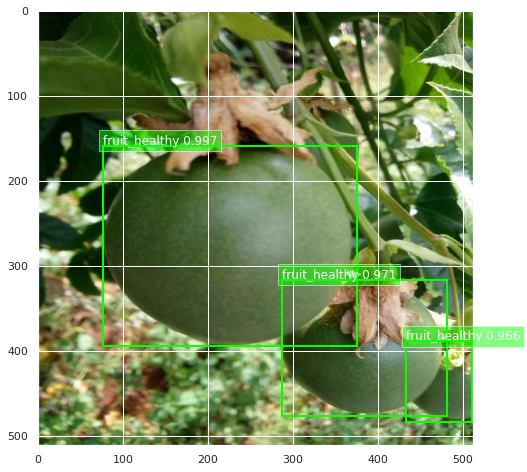

In [ ]:
net = gcv.model_zoo.get_model('ssd_512_resnet50_v1_custom', classes=CLASSES, pretrained_base=False)
net.load_parameters(f'{wrk_path}/ssd_512_resnet50_v1_passion.params')

x, image = gcv.data.transforms.presets.ssd.load_test(f'{test_path}/ID_IUJJG62B.jpg', 512)

cid, score, bbox = net(x)
ax = utils.viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=CLASSES, linewidth=2)
plt.show()

## Prediction

In [ ]:
test = pd.read_csv(path/'Test.csv')
test.shape

(931, 1)

In [ ]:
test.head()

,Image_ID
0,ID_IUJJG62B
1,ID_ZPNDRD4T
2,ID_AHFYB64P
3,ID_L8JZLNTF
4,ID_IFMUXGPL


In [ ]:
img_files = test['Image_ID'].values

In [ ]:
results = []

for img_id in img_files:
    x, image = gcv.data.transforms.presets.ssd.load_test(f'{test_path}/{img_id}.jpg', 512)
    cid, score, bbox = net(x)
    boxes = (bbox[0][:4]).asnumpy()
    scores = (score[0][:4]).asnumpy()
    labels = (cid[0][:4]).asnumpy()
    res = zip(boxes, labels, scores)

    for item in list(res):
        row_dict = {}
        row_dict['Image_ID'] = img_id
        row_dict['boxes'] = item[0]
        row_dict['labels'] = item[1][0]
        row_dict['confidence'] = item[2][0]
        results.append(row_dict)
            
sub_df = pd.DataFrame(results)

  0%|          | 0/931 [00:00<?, ?it/s]

In [ ]:
sub_df['ymin'] = sub_df['boxes'].apply(lambda x: x[1])
sub_df['xmin'] = sub_df['boxes'].apply(lambda x: x[0])
sub_df['ymax'] = sub_df['boxes'].apply(lambda x: x[3])
sub_df['xmax'] = sub_df['boxes'].apply(lambda x: x[2])

In [ ]:
sub_df.drop(['boxes'], axis=1, inplace=True)

In [ ]:
ix = [0,1,2]
sub_df = sub_df[sub_df.labels.isin(ix)]
sub_df['labels'] = le.inverse_transform(sub_df['labels'].astype(int))
sub_df.rename(columns={'labels': 'class'}, inplace=True)

In [ ]:
sub_df.head(2)

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,ID_IUJJG62B,fruit_healthy,0.997378,159.435455,76.718781,395.043610,376.154053
1,ID_IUJJG62B,fruit_healthy,0.971453,317.596649,287.646545,477.827911,481.227539


In [ ]:
sub_df.to_csv(f'{wrk_path}/submission_107.csv', index=False) 